In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [116]:
file = pd.ExcelFile("..\data\\food-twentieth-century-crop-statistics-1900-2017-xlsx.xlsx")
df = file.parse('CropStats')
df = df.set_index(df.columns[0])
df.index.name = None

## Clean Data
Columns with too many null values or meaningless information are dropped.  
Columns with unclear names are renamed.  
For the subnational column null values are filled up with corresponding values from the national column.  
For yield, production, and hectares, if one of them is null but the others in the same row are not, the null one can be calculated. Here we need to pay attention to not divide by 0. 

In [117]:
df.drop(['admin2', 'notes', 'Harvest_year'], axis=1, inplace=True)
df.rename(columns = {'admin0': 'national', 'admin1': 'subnational', 'hectares (ha)': 'hectares_ha', 'production (tonnes)': 'production_tonnes', 'yield(tonnes/ha)': 'yield_tonnes_ha'}, inplace=True)
df.loc[df['subnational'].isna(), 'subnational'] = df['national']
# Calculate yield
mask = df['yield_tonnes_ha'].isna() & ~df['production_tonnes'].isna() & ~df['hectares_ha'].isna() & df['hectares_ha'] != 0
df.loc[mask, 'yield_tonnes_ha'] = df['production_tonnes'] / df['hectares_ha']
df.dropna(subset=['yield_tonnes_ha'], inplace=True)
# Calculate production
mask = df['production_tonnes'].isna() & ~df['yield_tonnes_ha'].isna() & ~df['hectares_ha'].isna()
df.loc[mask, 'production_tonnes'] = df['yield_tonnes_ha'] * df['hectares_ha']
df.dropna(subset=['production_tonnes'], inplace=True)
# Calculate hectares
mask = df['hectares_ha'].isna() & ~df['yield_tonnes_ha'].isna() & ~df['production_tonnes'].isna()
df.loc[mask, 'hectares_ha'] = df['yield_tonnes_ha'] * df['production_tonnes']
df.dropna(subset=['hectares_ha'], inplace=True)
# The columns we just adapted just changed into objects, let's make them floats again
df['hectares_ha'] = df['hectares_ha'].astype(float)
df['production_tonnes'] = df['production_tonnes'].astype(float)
df['yield_tonnes_ha'] = df['yield_tonnes_ha'].astype(float)

In [118]:
df.describe()

,hectares_ha,production_tonnes,year,yield_tonnes_ha
count,3.415500e+04,3.415500e+04,34155.000000,34155.000000
mean,6.745161e+05,1.634547e+06,1956.119836,2.679773
std,1.616353e+06,5.003067e+06,38.730405,2.239175
min,1.000000e+00,0.000000e+00,1861.000000,0.000000
25%,3.642120e+04,7.022915e+04,1927.000000,1.137703
50%,1.800826e+05,3.302174e+05,1959.000000,1.881500
75%,6.426318e+05,1.243900e+06,1989.000000,3.486162
max,3.147000e+07,1.342875e+08,2019.000000,17.168477


In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34155 entries, 59 to 36706
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   national           34155 non-null  object 
 1   subnational        34155 non-null  object 
 2   crop               34155 non-null  object 
 3   hectares_ha        34155 non-null  float64
 4   production_tonnes  34155 non-null  float64
 5   year               34155 non-null  int64  
 6   yield_tonnes_ha    34155 non-null  float64
dtypes: float64(3), int64(1), object(3)
memory usage: 3.1+ MB


Let's look at the yield, production, and hectares distribution per crop.

<Axes: xlabel='crop', ylabel='yield_tonnes_ha'>

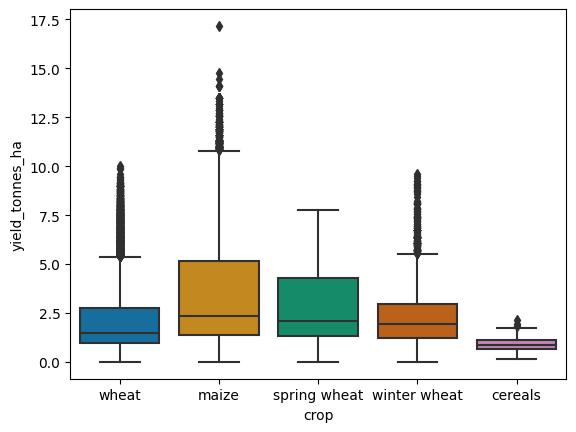

In [90]:
sns.boxplot(data=df, x='crop', y='yield_tonnes_ha', palette='colorblind')

<Axes: xlabel='crop', ylabel='production_tonnes'>

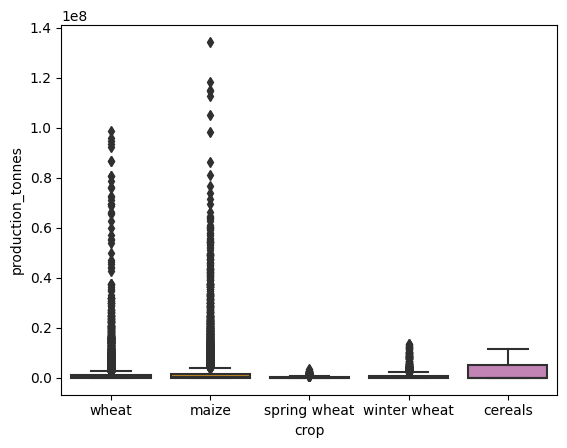

In [91]:
sns.boxplot(data=df, x='crop', y='production_tonnes', palette='colorblind')

<Axes: xlabel='crop', ylabel='hectares_ha'>

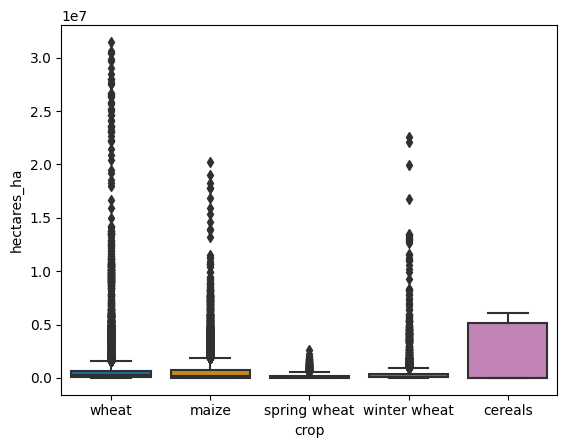

In [92]:
sns.boxplot(data=df, x='crop', y='hectares_ha', palette='colorblind')

We see everything is very right skewed, to the point that it is difficult to work with. Logarithmic transformations are the go to solution for that, so let's try that.

In [93]:
df['log_yield'] = np.log1p(df['yield_tonnes_ha'])
df['log_hectares'] = np.log1p(df['production_tonnes'])
df['log_production'] = np.log1p(df['hectares_ha'])

<Axes: xlabel='crop', ylabel='log_yield'>

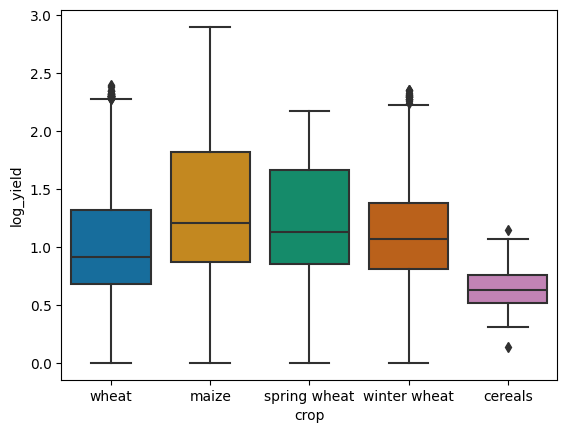

In [94]:
sns.boxplot(data=df, x='crop', y='log_yield', palette='colorblind')

<Axes: xlabel='crop', ylabel='log_hectares'>

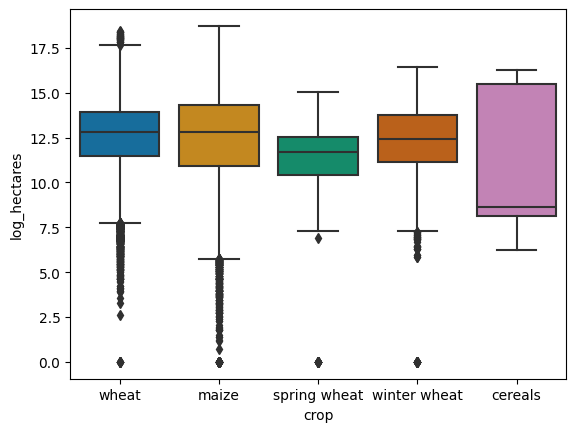

In [95]:
sns.boxplot(data=df, x='crop', y='log_hectares', palette='colorblind')

<Axes: xlabel='crop', ylabel='log_production'>

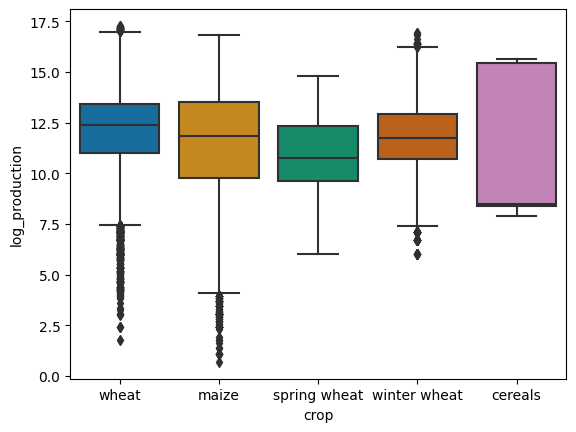

In [96]:
sns.boxplot(data=df, x='crop', y='log_production', palette='colorblind')

Much better, for now we will keep in the original columns as well because they might prove more valuable during the training of the models. This transformation also improves the stdev/mean ratio.  
We have a lot to look at here, to make things more manageable in the time we have for this project we have decided to only focus on the crop with the most available data.

In [97]:
df.groupby('crop').count()

,national,subnational,hectares_ha,production_tonnes,year,yield_tonnes_ha,log_yield,log_hectares,log_production
crop,,,,,,,,,
cereals,80,80,80,80,80,80,80,80,80
maize,13191,13191,13191,13191,13191,13191,13191,13191,13191
spring wheat,718,718,718,718,718,718,718,718,718
wheat,15479,15479,15479,15479,15479,15479,15479,15479,15479
winter wheat,4687,4687,4687,4687,4687,4687,4687,4687,4687


We see that wheat has the most rows, with 15479 values, so we will go with that one.

In [98]:
df = df[df['crop'] == 'wheat']

Now we don't need the crop column anymore.

In [ ]:
df.drop('crop', axis=1, inplace =True)

## Exploratory Data Analysis

I am now going for wheat, all countries

<Axes: >

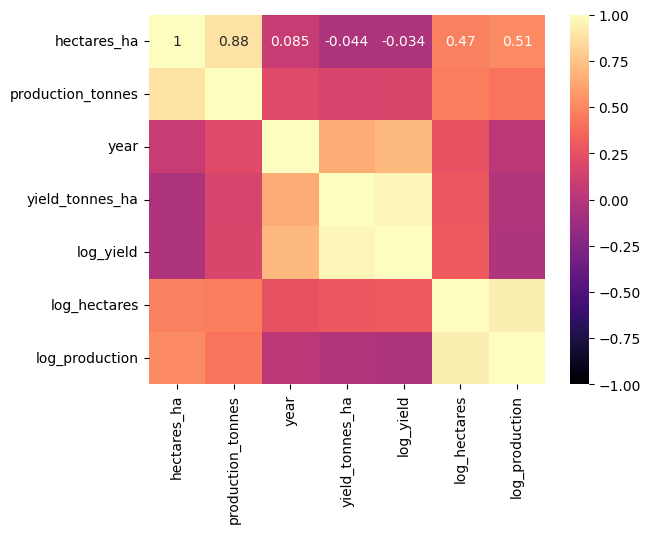

In [105]:
corr = df.corr(numeric_only=True)
sns.heatmap(corr, vmin=-1, cmap='magma', annot=True)

In [106]:
corr['yield_tonnes_ha'].sort_values(ascending=False)

yield_tonnes_ha      1.000000
log_yield            0.966420
year                 0.650178
log_hectares         0.296447
production_tonnes    0.161409
log_production      -0.019441
hectares_ha         -0.043814
Name: yield_tonnes_ha, dtype: float64

In [107]:
corr['log_yield'].sort_values(ascending=False)

log_yield            1.000000
yield_tonnes_ha      0.966420
year                 0.705160
log_hectares         0.307172
production_tonnes    0.172612
log_production      -0.033644
hectares_ha         -0.033975
Name: log_yield, dtype: float64

We see a lot of correlation in our dataset. We can obviously ignore the correlation between the columns with their corresponding logarithmic columns. We see high correlation between yield and year, as well as between yield and production and yield and log_hectares. It is interesting that there is much less correlation with hectares and log_production.

<Axes: xlabel='log_yield', ylabel='Count'>

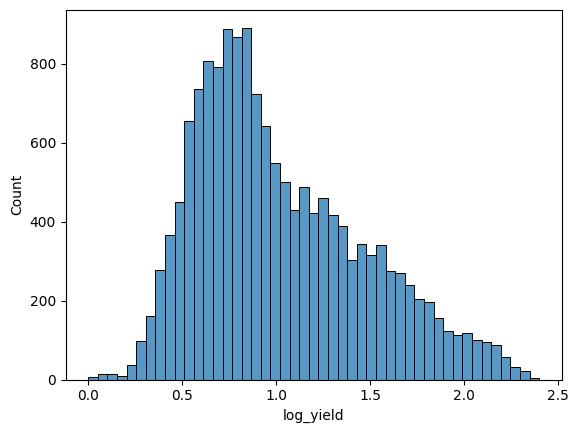

In [110]:
sns.histplot(data=df, x='log_yield')

<Axes: ylabel='log_yield'>

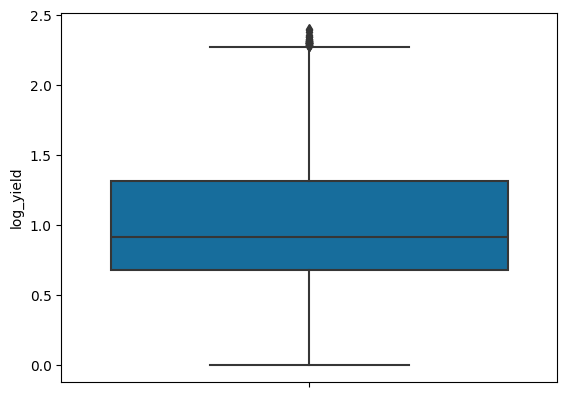

In [111]:
sns.boxplot(data=df, y='log_yield', palette='colorblind')

We can still see a slightly right skewed distribution for our target value, with no clear outliers.

<Axes: xlabel='year', ylabel='log_yield'>

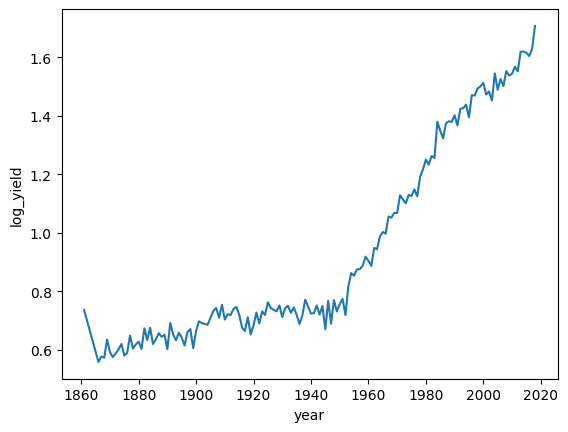

In [113]:
average_yield = df.groupby(['year'])['log_yield'].mean().reset_index()

sns.lineplot(data=average_yield, x='year', y='log_yield')

Looking at the average yield we see it go up throughout the years, especially after 1950.

<Axes: xlabel='year', ylabel='count'>

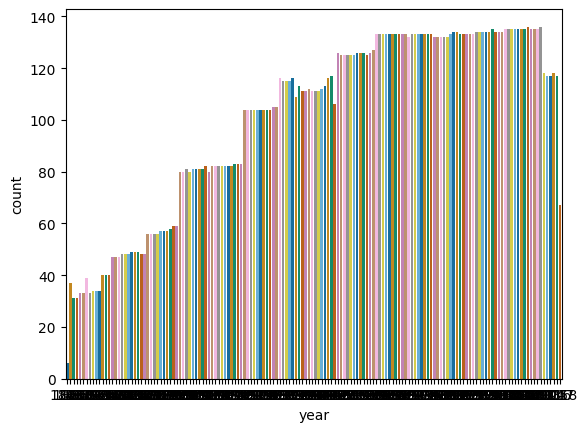

In [114]:
sns.countplot(data=df, x='year', palette='colorblind')

The above graph shows the amount of available values per year. It looks a little hectic but is does show that there have been more and more values available every year, with a drop in available data in the recent years

In summary, during the training of the models the following things should be considered:
- Remove logarithmic or original columns for yield, production, and hectares.